####BLOOM-DATE PREDICTION OF SAKURA

# Entrance Challenge: When Will the Sakura Bloom?

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2018 using the Japanese Meteorological Agency website (気象庁).

<p><u>Data Acquisition</u>-<br>
  The Dates of sakura-blooming were collected from the Japanese Meteorological Agency website. The following links shown below are the source of Sakura bloom-dates in our dataset.<br>From
  <li>http://www.data.jma.go.jp/sakura/data/sakura003_01.html</li>To
    <li> http://www.data.jma.go.jp/sakura/data/sakura003_06.html</li>The bloom-dates were storred in a CSV file named BloomDate.CSV. The weather-data of Tokyo for the last 51 years were stored Tokyo_en.CSV.  Then both datasets were combined in one CSV file named sakura.CSV that contains the complete information on weather and bloom-dates.

In [0]:
#import some necessary librairies
#data processing
import pandas as pd 

#numpy for mathematical computation 
import numpy as np # linear algebra

In [0]:
#and matplotlib & seaborn, for visualisation.
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
from IPython.display import display
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')

Data Manipulation, Mathematical Computation and Visualisation packages imported!


In [0]:
# Statistical packages used for transformations
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p #For box-com transformation
from scipy.stats.stats import pearsonr
print('Statistical packages imported!')

Statistical packages imported!


In [0]:
# Algorithms used for modeling
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
print('Algorithm packages imported!')

Algorithm packages imported!


In [0]:
# Pipeline and scaling preprocessing will be used for models that are sensitive
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and preprocessing packages imported!')

Pipeline and preprocessing packages imported!


In [0]:
# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Model selection packages imported!')

Model selection packages imported!


In [0]:
# To ignore annoying warning
import warnings

import warnings
warnings.filterwarnings('ignore')


#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) 

In [0]:
#check the files available in the directory
from subprocess import check_output
print(check_output(['ls', '/content/drive/My Drive/Sakura/db']).decode('utf8'))

#Now let's import and put the train and test datasets in  pandas dataframe
sakuradb = pd.read_csv('/content/drive/My Drive/Sakura/db/sakura.csv')
print('Dataset Imported!')

BloomDate.csv
sakura.csv
tokyo_en.csv

Dataset Imported!


In [0]:
#display the first five rows of the train dataset if necessary
pd.set_option('display.max_columns', None)
print('5 rows of Train dataset:')
print('Shape of the sakura dataset =',str(sakuradb.shape))
sakuradb.head()

5 rows of Train dataset:
Shape of the sakura dataset = (20561, 16)


,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom
0,0,1961,1,1,1011.7000,1012.4000,0.0000,0.0000,0.0000,2.1000,7.9000,-3.9000,41.0000,15.0000,8.6000,0.0000
1,1,1961,1,2,1020.2000,1021.0000,0.0000,0.0000,0.0000,1.5000,9.2000,-3.3000,51.0000,26.0000,8.7000,0.0000
2,2,1961,1,3,1021.3000,1022.1000,0.1000,0.8000,0.0000,2.5000,7.3000,-2.4000,58.0000,37.0000,5.4000,0.0000
3,3,1961,1,4,1004.6000,1005.3000,20.2000,13.9000,3.2000,4.7000,11.5000,0.6000,60.0000,38.0000,1.0000,0.0000
4,4,1961,1,5,1016.3000,1017.0000,0.0000,0.0000,0.0000,3.8000,7.7000,1.4000,33.0000,19.0000,8.3000,0.0000


<p>Lets split train and test data and reset the index column for both datasets</p>

In [0]:
#Split train and test 
traindb = sakuradb[(sakuradb.year != 1966)& (sakuradb.year != 1971)& 
                   (sakuradb.year != 1985)& (sakuradb.year != 1994)& 
                   (sakuradb.year != 2008)]
traindb = traindb.reset_index(drop=True)
testdb = sakuradb[(sakuradb.year == 1966)| (sakuradb.year == 1971)| 
                  (sakuradb.year == 1985)| (sakuradb.year == 1994)| 
                  (sakuradb.year == 2008)]
testdb = testdb.reset_index(drop=True)
print('Total size of Train and test Dataset =',str(testdb.shape[0]+traindb.shape[0]))

Total size of Train and test Dataset = 20561


<p>So Train and Test dataset are now properly splitted. And the combined size of train and test-db is equal to the actual dataset-sakuradb. </p>

***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

<p><u>Lets calculate total temperature from February 1st to the actual bloom-date  for each year and then get the Tmean for Tokyo</u></p>

In [0]:
#Lets get a list for train and test years
trainyears = traindb['year'].unique().tolist()
testyears = testdb['year'].unique().tolist()
total_temps = []

#check if there is only one bloom-date for each year
if(traindb[(traindb.bloom == 1)].shape[0] == len(trainyears)): print('So each year has one bloom-date.')

#calculate total temperature from February 1st to the actual bloom-date  for each year
for year in trainyears:
    beginPeriod = traindb[(traindb.year == year) & (traindb.month == 2) & 
                          (traindb.day == 1)].index[0]
    endPeriod = traindb[(traindb.year == year) & (traindb.bloom == 1)].index[0]
    duration = traindb[beginPeriod:endPeriod+1]
    total_max_temp = duration['max temp'].sum()
    total_temps.append(total_max_temp)

t_mean = np.average(total_temps)
print('The average of accumulated temperature for each year','\n', 'or Tmean for Tokyo is ',t_mean, 'Degree C')

So each year has one bloom-date.
The average of accumulated temperature for each year 
 or Tmean for Tokyo is  638.3557692307693 Degree C


<p>So 600 degree rule cannot be used for Tokyo as  Tmean for Tokyo is higher than 600 degree by 38 degree centigrade. Therefore Tmean = 638 degree has to be used to predict the bloom-date in Tokyo</p>

<p><u>Plotting Accumulated Max Temperature against Training Years</u></p>

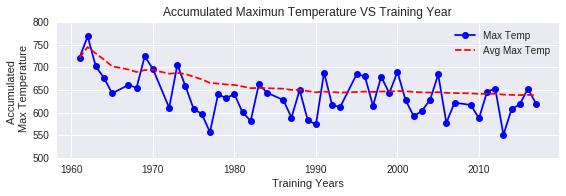

In [0]:
adding = 0
all_avg = []
for count in range(len(total_temps)):
    adding = adding + total_temps[count]
    avg = adding/(count+1)
    all_avg.append(avg)

plt.subplots(figsize=(9, 2.5))
plt.plot(trainyears,total_temps,'-bo',label='Max Temp')
plt.plot(trainyears,all_avg,'--r',label='Avg Max Temp')
plt.xlabel('Training Years')
plt.ylabel('Accumulated \n Max Temperature')
plt.ylim(500, 800)
plt.title('Accumulated Maximun Temperature VS Training Year', fontsize = 12)
plt.legend()
plt.show()

<p>So we can see that the accumulated Maximum Temperatures for most of the years are in between 600 and 700 degree centigrade. Here the dashed-line is representing average up-to a each year. From the line it can be easily understood that the accumulated Maximum Temperatures has gradually decreased over-time. The decreasing is clearly visible in the recent years</p>

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

<p><u>Declaring variables</u></p>

In [0]:
from datetime import date
from sklearn.metrics import r2_score

t600 = 600
bloom_dates_by_tmean = []
bloom_days_by_tmean = []

bloom_dates_by_t600 = []
bloom_days_by_t600 = []

actual_bloom_dates = []
actual_bloom_days = []

<p><u>Prediction bloom-dates of test-years using Tmean</u></p>

In [0]:
for year in testyears:
    beginPeriod = testdb[(testdb.year == year) & (testdb.month == 2) & 
                         (testdb.day == 1)].index[0]
    begin_date = date(year, int(testdb[beginPeriod:beginPeriod+1]['month']), 
                      int(testdb[beginPeriod:beginPeriod+1]['day']))
    threshold_temp = 0
    while(threshold_temp < t_mean):
        threshold_temp = threshold_temp + float(testdb[beginPeriod:beginPeriod+1]['max temp'])
        beginPeriod = beginPeriod+1 
    endPeriod = beginPeriod
    bloom_date = date(year, int(testdb[endPeriod:endPeriod+1]['month']), 
                      int(testdb[endPeriod:endPeriod+1]['day']))
    bloom_duration = bloom_date - begin_date
    bloom_dates_by_tmean.append(bloom_date)
    bloom_days_by_tmean.append(bloom_duration.days-1)

<p><u>Prediction bloom-dates of test-years using 600 degree rule</u></p>

In [0]:
for year in testyears:
    beginPeriod = testdb[(testdb.year == year) & (testdb.month == 2) & 
                         (testdb.day == 1)].index[0]
    begin_date = date(year, int(testdb[beginPeriod:beginPeriod+1]['month']), 
                      int(testdb[beginPeriod:beginPeriod+1]['day']))
    threshold_temp = 0
    while(threshold_temp < t600):
        threshold_temp = threshold_temp + float(testdb[beginPeriod:beginPeriod+1]['max temp'])
        beginPeriod = beginPeriod+1 
    endPeriod = beginPeriod
    bloom_date = date(year, int(testdb[endPeriod:endPeriod+1]['month']), 
                      int(testdb[endPeriod:endPeriod+1]['day']))
    bloom_duration = bloom_date - begin_date
    bloom_dates_by_t600.append(bloom_date)
    bloom_days_by_t600.append(bloom_duration.days-1)

<p><u>Making a list of actual bloom-dates</u></p>

In [0]:
for year in testyears: 
    beginPeriod = testdb[(testdb.year == year) & (testdb.month == 2) & 
                         (testdb.day == 1)].index[0]
    begin_date = date(year, int(testdb[beginPeriod:beginPeriod+1]['month']), 
                      int(testdb[beginPeriod:beginPeriod+1]['day']))
    endPeriod = testdb[(testdb.year == year) & (testdb.bloom == 1)].index[0]
    bloom_date = date(year, int(testdb[endPeriod:endPeriod+1]['month']), 
                      int(testdb[endPeriod:endPeriod+1]['day']))
    bloom_duration = (bloom_date - begin_date)
    actual_bloom_days.append(bloom_duration.days)
    actual_bloom_dates.append(bloom_date)

<p><u>Comparison of prediction for Tmean and 600-Degree rule with respect to actual bloom-dates</u></p>

In [0]:
print('Comparison of prediction for Tmean and 600-Degree rule','\n',
      'with respect to actual bloom-dates')  
percentile_list = pd.DataFrame({'Actual-bloom-dates' : actual_bloom_dates,
                                'Bloom_dates_by_Tmean' : bloom_dates_by_tmean,
                                'Bloom_dates_by_T600' : bloom_dates_by_t600 })
percentile_list

Comparison of prediction for Tmean and 600-Degree rule 
 with respect to actual bloom-dates


,Actual-bloom-dates,Bloom_dates_by_T600,Bloom_dates_by_Tmean
0,1966-03-20,1966-03-21,1966-03-24
1,1971-03-30,1971-03-28,1971-03-30
2,1985-04-03,1985-03-30,1985-04-02
3,1994-03-31,1994-03-29,1994-04-01
4,2008-03-22,2008-03-24,2008-03-26


<p><u>Error comparison of T600 and Tmean using Scatterplot</u></p>

In [0]:
ABD = actual_bloom_dates.copy()
BDTmean = bloom_dates_by_tmean.copy()
BDT600 = bloom_dates_by_t600.copy()
#Errors for T600 & Tmean
errorTmean = []
errorT600 = []
for count in range(len(ABD)):
    errorTmean.append(abs(ABD[count] - BDTmean[count]).days)
    errorT600.append(abs(ABD[count] - BDT600[count]).days)

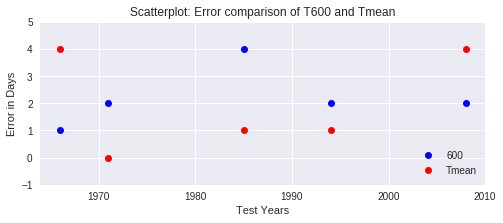

In [0]:
plt.subplots(figsize=(8, 3))
plt.plot(testyears,errorT600,'bo',label='600')
plt.plot(testyears,errorTmean,'ro',label='Tmean')
plt.xlabel('Test Years')
plt.ylabel('Error in Days')
plt.title('Scatterplot: Error comparison of T600 and Tmean')
plt.ylim(-1,5)
plt.legend()
plt.show() 

<p><u>Error comparison of T600 and Tmean using Barplot</u></p>

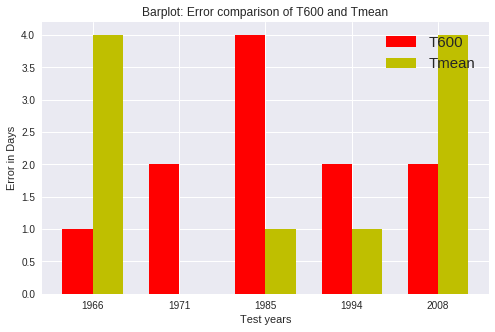

In [0]:
ind = np.arange(len(testyears))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
p1 = ax.bar(ind, errorT600, width, color='r')
p2 = ax.bar(ind + width, errorTmean, width,color='y')
ax.set_title('Barplot: Error comparison of T600 and Tmean')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(testyears)
ax.legend((p1[0], p2[0]), ('T600', 'Tmean'),loc='best', fontsize=15)
plt.ylabel('Error in Days')
plt.xlabel('Test years')
plt.show()

<p><u>Plot-discussion</u><br>From both scatter-plot and bar-plot we can see that the error of 600-degree-rule is considerably higher than Tmean Rule for the majority of years. On the other hand Tmean-rule shows less error though it showed higher error than 600-degree-rule for the years 1966 and 2008. So it is not always better. Therefore we can calculate the average of the predictions from both models to achieve more generalized results.</p>

<p><u>Calculating R2-score for Tmean and 600 degree rule</u></p>

In [0]:
actual_bloom_days_600degree = actual_bloom_days
predicted_bloom_days_by_t600 = bloom_days_by_t600
predicted_bloom_days_by_tmean = bloom_days_by_tmean
print('R2-Score for T600: ',r2_score(actual_bloom_days, bloom_days_by_t600))
print('R2-Score for Tmean: ',r2_score(actual_bloom_days, bloom_days_by_tmean))

R2-Score for T600:  0.6793002915451896
R2-Score for Tmean:  0.8323615160349854


<p>So Tmean Rule shows higher R2 score for the testdb </p>

***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

<p><u>Plotting Dj values for every year $j$ from 1961 to 2017</u></p>

In [0]:
import math
#trainyears =trainyears[ 0 : -1]
allyears = sakuradb['year'].unique().tolist()
dj_all = []
dj_all_by_day = []
dj_train = []
dj_test = []

#converting ϕ into decimal
theta = 35+(40/60)
coast_dist = 4.00

In [0]:
for year in allyears:
    beginPeriod = sakuradb[(sakuradb.year == year) & (sakuradb.month == 1) & 
                           (sakuradb.day == 1)].index[0]
    endPeriod = sakuradb[(sakuradb.year == year) & (sakuradb.month == 3) & 
                         (sakuradb.day == 31)].index[0]
    duration = sakuradb[beginPeriod:endPeriod+1]
    tf = duration['avg temp'].mean()
    dj = 136.75 - (7.689*theta) + (0.133* math.pow(theta, 2))- (1.307*np.log(coast_dist))+ (0.144*tf) + (0.285* math.pow(tf, 2))
    dj_all.append((round(dj)%31))
    dj_all_by_day.append(round(dj))

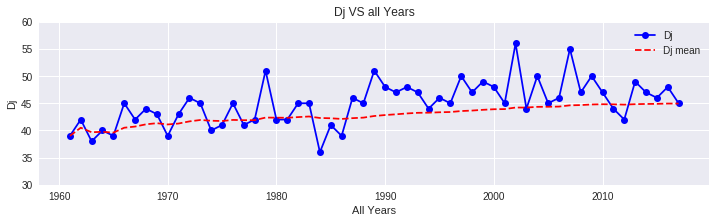

In [0]:
adding = 0
all_avg = []
for count in range(len(dj_all_by_day)):
    adding = adding + dj_all_by_day[count]
    avg = adding/(count+1)
    all_avg.append(avg)

plt.subplots(figsize=(12, 3))
plt.plot(allyears,dj_all_by_day,'-bo', label = 'Dj')
plt.plot(allyears,all_avg,'--r', label = 'Dj mean')
plt.xlabel('All Years')
plt.ylabel('Dj')
plt.ylim(30, 60)
plt.title('Dj VS all Years')
plt.legend()
plt.show()

<p><u>Plot-discussion</u><br>Here it can easily be understood that the values of Djs are higher than 30 but lower than 60 . Which means each Dj is actually any  day of the month- February. From the dashed-line of Dj-mean it is also visible that the average-Dj has increased over-time. So the last day of hybernation is gradually delaying over the years.</p>

<p><u>Storing Dj values separately for Train and Test Years</u></p>

In [0]:
for year in trainyears:
    beginPeriod = traindb[(traindb.year == year) & (traindb.month == 1) & 
                          (traindb.day == 1)].index[0]
    endPeriod = traindb[(traindb.year == year) & (traindb.month == 3) & 
                        (traindb.day == 31)].index[0]
    duration = traindb[beginPeriod:endPeriod+1]
    tf = duration['avg temp'].mean()
    dj = 136.75 - (7.689*theta) + (0.133* math.pow(theta, 2))- (1.307*np.log(coast_dist))+ (0.144*tf) + (0.285* math.pow(tf, 2))
    dj_train.append((round(dj)%31))

In [0]:
for year in testyears:
    beginPeriod = testdb[(testdb.year == year) & (testdb.month == 1) & 
                         (testdb.day == 1)].index[0]
    endPeriod = testdb[(testdb.year == year) & (testdb.month == 3) & 
                       (testdb.day == 31)].index[0]
    duration = testdb[beginPeriod:endPeriod+1]
    tf = duration['avg temp'].mean()
    dj = 136.75 - (7.689*theta) + (0.133* math.pow(theta, 2))- (1.307*np.log(coast_dist))+ (0.144*tf) + (0.285* math.pow(tf, 2))
    dj_test.append((round(dj)%31))    

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, etc) in the equation for $t_{s}$. 


<p><u>Calculating DTSmean for each Ea value</u></p>

In [0]:
const_temp = 17+273.15
dtsj_per_ea = []
dts_mean_per_ea = []
all_ea = list(range(5, 41))
for ea in all_ea:
    dtsj_per_year = []
    for count in range(len(trainyears)):
        beginPeriod = traindb[(traindb.year == trainyears[count]) & (traindb.month == 2) & 
                              (traindb.day == dj_train[count])].index[0]
        endPeriod = traindb[(traindb.year == trainyears[count]) & (traindb.bloom == 1)].index[0]
        duration = traindb[beginPeriod:endPeriod+1]
        duration['avg temp kelvin'] = duration['avg temp']+273.15
        duration['ts'] = np.exp((ea*(duration['avg temp kelvin'] - const_temp))/
                                (duration['avg temp kelvin']*const_temp*0.00198588))
        dtsj = duration['ts'].sum()
        dtsj_per_year.append(dtsj)
    dtsj_per_ea.append(dtsj_per_year)
    dts_mean_per_ea.append(np.average(dtsj_per_year))

<p><u>Plotting DTS VS Ea for all Train years</u></p>

Average DTSmean over all Ea =  15.088145130425694


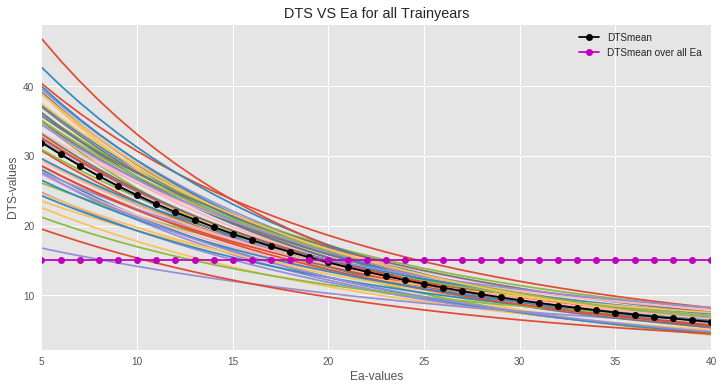

In [0]:
avg_dts_mean = sum(dts_mean_per_ea)/len(dts_mean_per_ea)
print('Average DTSmean over all Ea = ',avg_dts_mean)

avg_dts_mean = [avg_dts_mean for i in range(len(all_ea))]

plt.subplots(figsize=(12, 6))
dtsj_for_each_year = []

for i in range(len(trainyears)):
    dtsj_for_each_ea = []
    for j in range(len(all_ea)):
        dtsj_for_each_ea.append(dtsj_per_ea[j][i])
    dtsj_for_each_year.append(dtsj_for_each_ea)  

for i in range(len(trainyears)):
    plt.plot(all_ea,dtsj_for_each_year[i]) 

plt.xlabel("Ea-values")    
plt.ylabel("DTS-values")                               
plt.title("DTS VS Ea for all Trainyears")    
plt.plot(all_ea, dts_mean_per_ea,"-ko",label="DTSmean")
plt.xlim(5, 40)
plt.plot(all_ea,avg_dts_mean,"-mo",label="DTSmean over all Ea")
plt.legend()
plt.show()

<p><u>Plot-Discussion</u><br>From the above plot it is clearly visible that the red-dotted DTSmean cluve has passed through the middle of all the curves for all the years of training dataset. Now we have to figure-out the best Ea and DTSmean combination for which the squared-error on test-data becomes minimum. </p>

### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

<p><u>Predicting Bloom-dates of all train-years for each Ea value</u></p>

In [0]:
bloom_dates_per_ea = []
bloom_days_per_ea = []
traindb['avg temp kelvin'] = traindb['avg temp']+273.15
for value in range(len(all_ea)):
    bloom_dates_by_DTSmean = []
    bloom_days_by_DTSmean = []
    for count in range(len(trainyears)):
        marginPeriod = traindb[(traindb.year == trainyears[count]) & 
                               (traindb.month == 2) & (traindb.day == 1)].index[0]
        margin_date = date(trainyears[count], int(traindb[marginPeriod:marginPeriod+1]['month']), 
                           int(traindb[marginPeriod:marginPeriod+1]['day']))
        beginPeriod = traindb[(traindb.year == trainyears[count]) & (traindb.month == 2) & 
                              (traindb.day == dj_train[count])].index[0]
        begin_date = date(trainyears[count], int(traindb[beginPeriod:beginPeriod+1]['month']), 
                          int(traindb[beginPeriod:beginPeriod+1]['day']))
        threshold_dts = 0
        while(threshold_dts <= dts_mean_per_ea[value]):
            avg_temp = float(traindb[beginPeriod:beginPeriod+1]['avg temp kelvin'])
            ts = np.exp((all_ea[value]*(avg_temp-const_temp))/(avg_temp*const_temp*0.00198588))
            threshold_dts = threshold_dts + ts
            beginPeriod = beginPeriod+1
        endPeriod = beginPeriod
        bloom_date = date(trainyears[count], int(traindb[endPeriod:endPeriod+1]['month']), 
                          int(traindb[endPeriod:endPeriod+1]['day']))
        bloom_duration = bloom_date - begin_date
        bloom_dates_by_DTSmean.append(bloom_date)
        bloom_days_by_DTSmean.append(bloom_duration.days)
    bloom_dates_per_ea.append(bloom_dates_by_DTSmean)
    bloom_days_per_ea.append(bloom_days_by_DTSmean)

<p><u>Storring actual bloom-dates for each train-year</u></p>

In [0]:
actual_bloom_days = []
actual_bloom_dates = []
for count in range(len(trainyears)):
    marginPeriod = traindb[(traindb.year == trainyears[count]) & 
                           (traindb.month == 2) & (traindb.day == 1)].index[0]
    margin_date = date(trainyears[count], int(traindb[marginPeriod:marginPeriod+1]['month']), 
                       int(traindb[marginPeriod:marginPeriod+1]['day']))
    beginPeriod = traindb[(traindb.year == trainyears[count]) & (traindb.month == 2) & 
                          (traindb.day == dj_train[count])].index[0]
    begin_date = date(year, int(traindb[beginPeriod:beginPeriod+1]['month']), 
                      int(traindb[beginPeriod:beginPeriod+1]['day']))
    endPeriod = traindb[(traindb.year == trainyears[count]) & (traindb.bloom == 1)].index[0]
    bloom_date = date(year, int(traindb[endPeriod:endPeriod+1]['month']), 
                      int(traindb[endPeriod:endPeriod+1]['day']))
    bloom_duration = bloom_date - begin_date
    actual_bloom_days.append(bloom_duration.days)
    actual_bloom_dates.append(bloom_date)

<p><u>Calculating optimal Ea that minimizes squared-error on trainDB</u></p>

In [0]:
mse_per_ea = []
for value in range(len(all_ea)):
    squared_errors = []
    for count in range(len(trainyears)):
        error = (bloom_days_per_ea[value][count]) - (actual_bloom_days[count])
        squared_errors.append(math.pow(error, 2))
    mse_per_ea.append(np.mean(squared_errors))  

min_error = np.min(mse_per_ea)
for value in range(len(all_ea)):
    if(mse_per_ea[value] == min_error): 
        best_value = value
        best_ea = all_ea[value]
        best_dtsm = dts_mean_per_ea[value]
    
print('So for the ',best_value,'th Ea the mean-squared-error is found minimum ')
print('The value of',best_value,'th Ea is: ',best_ea,'which is considered optimal')
print('The value of DTSmean for optimal Ea (= ',best_ea, ') is: ',best_dtsm)  

So for the  23 th Ea the mean-squared-error is found minimum 
The value of 23 th Ea is:  28 which is considered optimal
The value of DTSmean for optimal Ea (=  28 ) is:  10.165189335489261


<p><u>Plotting mean-squared errors with respect to Ea values </u></p>

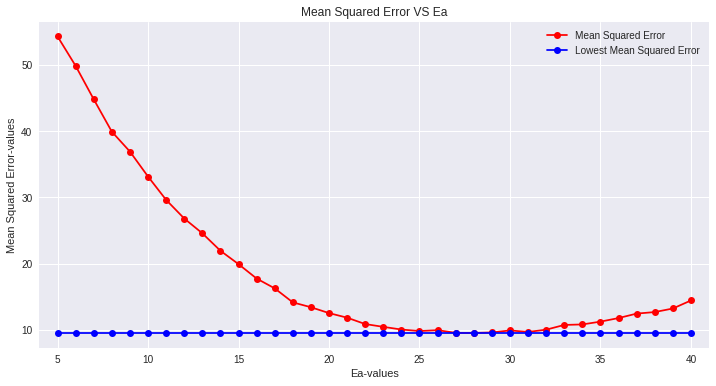

In [0]:
min_mse = [min_error for i in range(len(all_ea))]
plt.subplots(figsize=(12, 6))
plt.plot(all_ea, mse_per_ea,"-ro",label="Mean Squared Error")
plt.xlim(4, 41)
plt.plot(all_ea,min_mse,"-bo",label="Lowest Mean Squared Error")
plt.xlabel("Ea-values")    
plt.ylabel("Mean Squared Error-values")                               
plt.title("Mean Squared Error VS Ea")
plt.legend()
plt.show()

<p>As we can see that the blue straight-line representing the lowest mean squared error intersects the mean-squared-error curve at its lowest value where Ea-value is found 28. Therefore the optimal Ea calculation is proved to be correct.</p>

### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

<p><u>Predicting bloom-dates of test-years using the best Ea and DTSmean</u></p>

In [0]:
predicted_bloom_dates = []
predicted_bloom_days = []
testdb['avg temp kelvin'] = testdb['avg temp']+273.15
for count in range(len(testyears)):
    beginPeriod = testdb[(testdb.year == testyears[count]) & (testdb.month == 2) & 
                         (testdb.day == dj_test[count])].index[0]
    begin_date = date(testyears[count], int(testdb[beginPeriod:beginPeriod+1]['month']), 
                      int(testdb[beginPeriod:beginPeriod+1]['day']))
    threshold_dts = 0
    while(threshold_dts < best_dtsm):
        avg_temp = float(testdb[beginPeriod:beginPeriod+1]['avg temp kelvin'])
        ts = np.exp((best_ea*(avg_temp-const_temp))/(avg_temp*const_temp*0.00198588))
        threshold_dts = threshold_dts + ts
        beginPeriod = beginPeriod+1
    endPeriod = beginPeriod
    bloom_date = date(testyears[count], int(testdb[endPeriod:endPeriod+1]['month']), 
                      int(testdb[endPeriod:endPeriod+1]['day']))
    bloom_duration = bloom_date - begin_date
    predicted_bloom_dates.append(bloom_date)
    predicted_bloom_days.append(bloom_duration.days-1)

<p><u>Storring actual bloom-dates for each test-year</u></p>

In [0]:
actual_bloom_days = []
actual_bloom_dates = []
for count in range(len(testyears)):
    marginPeriod = testdb[(testdb.year == testyears[count]) & 
                          (testdb.month == 2) & (testdb.day == 1)].index[0]
    margin_date = date(testyears[count], int(testdb[marginPeriod:marginPeriod+1]['month']), 
                       int(testdb[marginPeriod:marginPeriod+1]['day']))
    beginPeriod = testdb[(testdb.year == testyears[count]) & (testdb.month == 2) & 
                         (testdb.day == dj_test[count])].index[0]
    begin_date = date(testyears[count], int(testdb[beginPeriod:beginPeriod+1]['month']), 
                      int(testdb[beginPeriod:beginPeriod+1]['day']))
    endPeriod = testdb[(testdb.year == testyears[count]) & (testdb.bloom == 1)].index[0]
    bloom_date = date(testyears[count], int(testdb[endPeriod:endPeriod+1]['month']), 
                      int(testdb[endPeriod:endPeriod+1]['day']))
    bloom_duration = bloom_date - begin_date
    actual_bloom_days.append(bloom_duration.days)
    actual_bloom_dates.append(bloom_date) 

<p><u>Visualizing prediction-errors on test-db</u></p>

In [0]:
ABD = actual_bloom_dates.copy()
PRD = predicted_bloom_dates.copy()
errors = []

for count in range(len(ABD)):
    errors.append(abs(ABD[count] - PRD[count]).days)

print('Comparison of Predicted-Bloom-dates','\n','with respect to Actual bloom-dates')  
percentile_list = pd.DataFrame({'Actual-bloom-dates' : ABD,
                                'Predicted-bloom-dates' : PRD,
                                'Prediction-error' : errors})
percentile_list

Comparison of Predicted-Bloom-dates 
 with respect to Actual bloom-dates


,Actual-bloom-dates,Predicted-bloom-dates,Prediction-error
0,1966-03-20,1966-03-21,1
1,1971-03-30,1971-03-30,0
2,1985-04-03,1985-04-02,1
3,1994-03-31,1994-04-02,2
4,2008-03-22,2008-03-24,2


<p><u>Plotting prediction-errors on test-db</u></p>

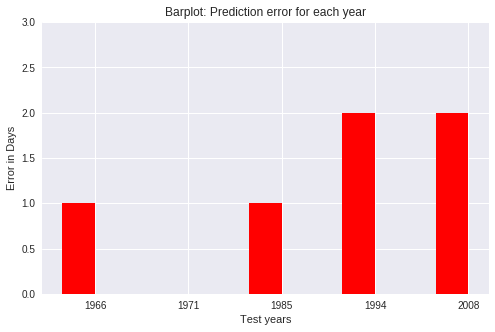

In [0]:
ind = np.arange(len(testyears))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
p1 = ax.bar(ind, errors, width, color='r')
ax.set_title('Barplot: Prediction error for each year')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(testyears)
plt.ylabel('Error in Days')
plt.xlabel('Test years')
plt.ylim(0, 3)
plt.show()

<p><u>Plot-discussion</u><br>From the above error-plot it is observed that the errors generated by the DTS method is much less than the Tmean method of problem 1. Here the maximum-error is also decreased by half compared to the Tmean method. For the first three samples the difference in between actual and predicted bloom-days was only one day maximum. </p>

<p><u>Calculating R2 score</u></p>

In [0]:
actual_bloom_days_dts = actual_bloom_days
predicted_bloom_days_by_dts = predicted_bloom_days
print('Final R2-score for the Linear-regression model: ',r2_score(actual_bloom_days, predicted_bloom_days))

Final R2-score for the Linear-regression model:  0.9712171052631579


### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

1.According to the mentioned model and datasets, there is an assumption that the average temperature of a single day is sustained throughout the day. This is not the case in real life as the temperature can flactuate even from hour to hour. So if the fluctuations of the temperature could be added, the accuracy and could possibly be improved.



2.There are different species of cherry trees from the Prunus genus. Different species of trees might have different type if implecations to different changes of variables. We did not take that into account. If we can take those things into consideration, accuracy might be improved.

<p><u>Discussion on Improvement of the Model</u><br><br>

  <ul>1. Number of years taken into consideration for both training and testing should be increased for better resolution.</ul> 
  <ul>2. More features relevant to sakura-blooming could be considered alongside the temperature.</ul> 
  <ul>3. The assumptions made to establish the model might not withstand under certain circumstances.</ul> 
       <ul>4. Both the Arrhenius activation energy Ea and the rate constant k are experimentally determined</ul>
    <ul>5. The equation of Hayashi et al.(2012) for determining the end of Hibernation is just a mere approximation. It can be modified considering discrepencies.</ul>
       <ul>6. Catalysts increase the rate of reaction. Presence of such catalysts in an area's soil can be investigated</ul>
       <ul>7. The activation energy for the reaction increases with temperature. So Ea decreases with T and therefore Ea is not completely independent of T</ul>
  <ul>8. R-squared score can sometime mislead. The score may also be too-low or too-high when the test-dataset is smaller. Proper alternative can be taken into consideration to justify model-performance.</ul> <br>
These are the suggestions in particular. I believe the prediction can be perfected further by applying several modifications in the equations and training the model with more data</p>

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

<p><u>Dataset preparation for ANN</u><br>A sincere observation of the Data shows that the Bloom-days occur within the first 4 months of a year. The Feature-values within the range of Hibernation Phase and Bloom Date can be considered as the most significant as they have direct impact on the Bloom Date. The effect of the feature-values for other months is  not significant to predict bloom-date in this case. Therefore the first 4 months of each year have been focused. Average of each column for the first 4 months has been considered as a feature for each year. Thus we will produce one row for each year in the new dataset for ANN.</p>

In [0]:
sakurayears = sakuradb['year'].unique().tolist()
sakurayears = sakurayears[ 0 : -1]
actual_bloom_days = []
#get actual bloom-dates
for year in sakurayears: 
    beginPeriod = sakuradb[(sakuradb.year == year) & (sakuradb.month == 1) 
                           & (sakuradb.day == 1)].index[0]
    begin_date = date(year, int(sakuradb[beginPeriod:beginPeriod+1]['month']), 
                      int(sakuradb[beginPeriod:beginPeriod+1]['day']))
    endPeriod = sakuradb[(sakuradb.year == year) & 
                         (sakuradb.bloom == 1)].index[0]
    bloom_date = date(year, int(sakuradb[endPeriod:endPeriod+1]['month']), 
                      int(sakuradb[endPeriod:endPeriod+1]['day']))
    bloom_duration = (bloom_date - begin_date)
    actual_bloom_days.append(bloom_duration.days)

columns = list(sakuradb)[4:-1]

all_column_mean = []
for column in columns:
    column_mean_per_year = []
    for year in sakurayears:
        beginPeriod = sakuradb[(sakuradb.year == year) & (sakuradb.month == 1) & 
                               (sakuradb.day == 1)].index[0]
        endPeriod = sakuradb[(sakuradb.year == year) & (sakuradb.month == 4) & 
                             (sakuradb.day == 30)].index[0]
        duration = sakuradb[beginPeriod:endPeriod+1]
        mean = duration[column].mean()
        column_mean_per_year.append(mean)
    all_column_mean.append(column_mean_per_year)  

<p><u>Lets discover the modified dataset</u></p>

In [0]:
sakuradb = pd.DataFrame(all_column_mean).T
sakuradb.columns = columns
sakuradb['bloom day'] = actual_bloom_days
sakuradb['year'] = sakurayears
sakuradb.head(9)

,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom day,year
0,1014.5358,1015.2492,3.1017,0.9992,0.3058,7.8333,13.1867,3.3633,56.7917,35.6917,6.4033,90,1961
1,1012.7275,1013.4400,2.0308,0.6017,0.2000,8.2167,13.6117,3.3400,55.0167,33.8167,6.6508,90,1962
2,1012.3967,1013.1100,1.5358,0.4075,0.1175,7.3908,12.8475,2.6150,55.4750,33.6583,6.8617,90,1963
3,1017.6661,1018.3777,3.3264,0.8893,0.2223,8.1273,12.5529,4.1091,62.0248,43.5868,4.9835,92,1964
4,1009.8208,1014.2183,1.5833,0.5333,0.2208,6.7992,11.2733,2.6267,53.0250,34.9917,6.6633,91,1965
5,1009.5825,1013.9542,3.1600,1.0558,0.3342,8.7483,13.0767,4.4858,55.6833,38.0667,5.2367,78,1966
6,1012.8858,1017.2792,2.0867,0.6800,0.1833,8.3700,12.6458,4.0408,53.7750,37.4417,5.9150,88,1967
7,1010.8570,1015.2388,2.2231,0.7066,0.2686,8.5711,13.0562,4.2050,51.5620,33.9421,6.4050,88,1968
8,1011.0767,1015.4667,2.9042,0.7792,0.2792,8.4783,12.6425,4.2750,58.8083,40.1083,5.0275,95,1969


In [0]:
sakuradb.shape

(56, 13)

<p><u>Split train and test datasets</u></p>

In [0]:
 traindb = sakuradb[(sakuradb.year != 1966)& (sakuradb.year != 1971)& (sakuradb.year != 1985)& 
                   (sakuradb.year != 1994)& (sakuradb.year != 2008)]

traindb = traindb.reset_index(drop=True)
testdb = sakuradb[(sakuradb.year == 1966)| (sakuradb.year == 1971)| (sakuradb.year == 1985)| 
                  (sakuradb.year == 1994)| (sakuradb.year == 2008)]
testdb = testdb.reset_index(drop=True)
testdb.shape[0]+traindb.shape[0]

56

In [0]:
traindb.head()

,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom day,year
0,1014.5358,1015.2492,3.1017,0.9992,0.3058,7.8333,13.1867,3.3633,56.7917,35.6917,6.4033,90,1961
1,1012.7275,1013.4400,2.0308,0.6017,0.2000,8.2167,13.6117,3.3400,55.0167,33.8167,6.6508,90,1962
2,1012.3967,1013.1100,1.5358,0.4075,0.1175,7.3908,12.8475,2.6150,55.4750,33.6583,6.8617,90,1963
3,1017.6661,1018.3777,3.3264,0.8893,0.2223,8.1273,12.5529,4.1091,62.0248,43.5868,4.9835,92,1964
4,1009.8208,1014.2183,1.5833,0.5333,0.2208,6.7992,11.2733,2.6267,53.0250,34.9917,6.6633,91,1965


In [0]:
testdb

,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom day,year
0,1009.5825,1013.9542,3.1600,1.0558,0.3342,8.7483,13.0767,4.4858,55.6833,38.0667,5.2367,78,1966
1,1010.9492,1015.3467,2.2625,0.6750,0.2250,8.2192,12.4325,4.2917,54.9500,36.7250,5.8192,88,1971
2,1012.2500,1016.6433,4.0208,1.0833,0.4042,8.1217,11.9217,4.6758,61.7750,43.2667,5.0992,92,1985
3,1010.1483,1014.5233,2.5167,0.8042,0.2458,8.9967,12.7792,5.3492,52.8333,34.4750,6.2283,89,1994
4,1011.2512,1015.7050,3.5868,1.0248,0.3471,9.2132,13.0702,5.8116,49.3058,31.2975,5.9240,81,2008


###ANN model from scratch using Tensorflow 

###12.1 Importing

In [0]:
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid

# To avoid watching warnings for TensorFlow:
import logging
def keep_every_nth_info(n):
    i = -1
    def filter_record(record):
        nonlocal i
        i += 1
        return int( i % n == 15)
    return filter_record
logging.getLogger('tensorflow').addFilter(keep_every_nth_info(15))
zero = 0

###12.2 Functions to load and process data



<p> Load-data function loads the already processed data for ANN and shows its shape. And the Pre-process-data function is created to do one-hot encoding of categorical columns. Though we have already created dummies...this is Just to be sure. If there is any column left that still containing string...we will one-hot encode it.</p>

In [0]:
def load_data(train_path, test_path):
    train_data = train_path
    test_data = test_path
    print("number of training examples = " + str(train_data.shape[zero]))
    print("number of test examples = " + str(test_data.shape[zero]))
    print("train shape: " + str(train_data.shape))
    print("test shape: " + str(test_data.shape))
    return train_data, test_data
  
def pre_process_data(df):
    # one-hot encode categorical values
    df = pd.get_dummies(df)
    return df

###12.3 Function to Create Mini-batches

```
# We will make a function to create mini-batches from train dataset
```





```
# Parameter description:
    :param train_set: data set with the examples
    :param train_labels: data set with the labels
    :param mini_batch_size: mini batch size
    :return: mini batches
```



In [0]:
def mini_batches(train_set, train_labels, mini_batch_size):
    
    set_size = train_set.shape[zero]
    batches = []
    num_complete_minibatches = set_size // mini_batch_size

    for k in range(zero, num_complete_minibatches):
        mini_batch_x = train_set[k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch_y = train_labels[k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_x, mini_batch_y)
        batches.append(mini_batch)

    if set_size % mini_batch_size != zero:
        mini_batch_x = train_set[(set_size - (set_size % mini_batch_size)):]
        mini_batch_y = train_labels[(set_size - (set_size % mini_batch_size)):]
        mini_batch = (mini_batch_x, mini_batch_y)
        batches.append(mini_batch)

    return batches

###12.4 Mathematical Functions

####12.4.1 Place-holder 



```
# Parameter descriptions:
Function-Name: place-holders
Creates the placeholders for the tensorflow session.
    :param input_size: scalar, input size
    :param output_size: scalar, output size
    :return: X  placeholder for the data input, of shape [None, input_size] and dtype "float"
    :return: Y placeholder for the input labels, of shape [None, output_size] and dtype "float"
```



In [0]:
def create_placeholders(input_size, output_size):

    x = tf.placeholder(shape=(None, input_size), dtype=tf.float32, name="X")
    y = tf.placeholder(shape=(None, output_size), dtype=tf.float32, name="Y")

    return x, y

####12.4.2 Forward-propagation



```
# Function-Name: forward-propagation
Implement forward propagation with dropout for the [LINEAR->RELU]*(L-1)->LINEAR-> computation
    :param x: data, pandas array of shape (input size, number of examples)
    :param parameters: output of initialize_parameters()
    :param keep_prob: probability to keep each node of the layer
    :param hidden_activation: activation function of the hidden layers
    :return: last LINEAR value
```



In [0]:
def forward_propagation(x, parameters, keep_prob=1, hidden_activation='relu'):

    a_dropout = x
    n_layers = len(parameters) // 2  # number of layers in the neural network

    for l in range(1, n_layers):
        a_prev = a_dropout
        a_dropout = linear_activation_forward(a_prev, parameters['w%s' % l], 
                                              parameters['b%s' % l], hidden_activation)

        if keep_prob < 1:
            a_dropout = tf.nn.dropout(a_dropout, keep_prob)

    al = tf.matmul(a_dropout, parameters['w%s' % n_layers]) + parameters['b%s' % n_layers]

    return al

####12.4.3  Linear Activation Function



```
# Function-Name: linear-activation-forward    
Implement the forward propagation for the LINEAR->ACTIVATION layer
    :param a_prev: activations from previous layer (or input data): (size of previous layer, number of examples)
    :param w: weights matrix: numpy array of shape (size of current layer, size of previous layer)
    :param b: bias vector, numpy array of shape (size of the current layer, 1)
    :param activation: the activation to be used in this layer, stored as a text string: 'sigmoid' or 'relu'
    :return: the output of the activation function, also called the post-activation value
```



In [0]:
def linear_activation_forward(a_prev, w, b, activation):
    
    a = None
    if activation == "sigmoid":
        z = tf.matmul(a_prev, w) + b
        a = tf.nn.sigmoid(z)

    elif activation == "relu":
        z = tf.matmul(a_prev, w) + b
        a = tf.nn.relu(z)

    elif activation == "leaky-relu":
        z = tf.matmul(a_prev, w) + b
        a = tf.nn.leaky_relu(z)

    return a

####12.4.4 Prameter-Initialization



```
# Function-Name: initialize_parameters
    :param layer_dims: python array (list) containing the dimensions of each layer in our network
    :return: python dictionary containing your parameters: w1, b1, ..., wn ,bn:
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
```



In [0]:
#Function for parameter initialization
def initialize_parameters(layer_dims, weight_initializer):

    parameters = {}
    n_layers = len(layer_dims) 
    
    for l in range(1, n_layers):
        if(weight_initializer == 'random-normal'):
            parameters['w' + str(l)] = tf.get_variable('w' + str(l), [layer_dims[l - 1], layer_dims[l]],
                                                   initializer = tf.random_normal_initializer)
        else:
            parameters['w' + str(l)] = tf.get_variable('w' + str(l), [layer_dims[l - 1], layer_dims[l]],
                                                   initializer = tf.contrib.layers.xavier_initializer())
        parameters['b' + str(l)] = tf.get_variable('b' + str(l), [layer_dims[l]], 
                                                   initializer=tf.zeros_initializer())

    return parameters

####12.4.5 Cost-computation



```
# Function-Name: Compute-cost
    :param z3: output of forward propagation (output of the last LINEAR unit)
    :param y: "true" labels vector placeholder, same shape as Z3
    :return: Tensor of the cost function (RMSE as it is a regression)
```



In [0]:
#Defining how to compute cost-function
def compute_cost(z3, y):
    
    cost = tf.sqrt(tf.reduce_mean(tf.square(y - z3)))

    return cost

####12.4.6 Prediction



```
# Function-Name: predict
make a prediction based on a data set and parameters
    :param data: based data set
    :param parameters: based parameters
    :return: array of predictions
```



In [0]:
#A function to provide prediction
def predict(data, parameters):

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)

        dataset = tf.cast(tf.constant(data), tf.float32)
        fw_prop_result = forward_propagation(dataset, parameters)
        prediction = fw_prop_result.eval()

    return prediction

####12.4.7 RMS and Log-RMS Calculation



```
# Function-Name: rmse and Function-name: rmsle
calculate cost between two data sets
    :param predictions: data set of predictions
    :param labels: data set of labels (real values)
    :return: percentage of correct predictions
```



In [0]:
#Function to calculate Root-Mean-Square-Error: RMS error
def rmse(predictions, labels):

    prediction_size = predictions.shape[zero]
    prediction_cost = np.sqrt(np.sum(np.square(labels - predictions)) / prediction_size)

    return prediction_cost

#Function to calculate RMS logarithmic error
def rmsle(predictions, labels):

    prediction_size = predictions.shape[zero]
    prediction_cost = np.sqrt(np.sum(np.square(np.log(predictions + 1) - np.log(labels + 1))) / prediction_size)

    return prediction_cost

####12.4.8 L2 Regularization



```
# Function-name: L2 Regularizer
Function to apply l2 regularization to the model
    :param cost: usual cost of the model
    :param l2_beta: beta value used for the normalization
    :param parameters: parameters from the model (used to get weights values)
    :param n_layers: number of layers of the model
    :return: cost updated
```



In [0]:
#Defining a function for L2-regularization
def l2_regularizer(cost, l2_beta, parameters, n_layers):

    regularizer = zero
    for i in range(1, n_layers):
        regularizer += tf.nn.l2_loss(parameters['w%s' % i])

    cost = tf.reduce_mean(cost + l2_beta * regularizer)

    return cost

###12.5 Functions to Generate Output

####12.5.1 Generate Kaggle-Submission File



```
# Parameter description:
    :param test_ids: vector with test dataset ids
    :param predictions: vector with test dataset predictions
    :param id_column: name of the output id column
    :param predction_column: name of the output predction column
    :param file_name: string for the output file name
    :return: output a csv with ids ands predictions
```



In [0]:
def output_submission(test_ids, predictions, id_column, predction_column, file_name):

    print('Preparing submission file...')
    with open('/content/drive/My Drive/housePrice/hpdb/' + file_name, 'w') as submission:
        writer = csv.writer(submission)
        writer.writerow([id_column, predction_column])
        for test_id, test_prediction in zip(test_ids, predictions):
            writer.writerow([test_id, test_prediction])
    print('File Ready')

####12.5.2 Generate Submission-File Name



```
# builds a string (submission file name), based on the model parameters
    :param layers_dims: model layers dimensions
    :param num_epochs: model number of epochs
    :param lr_decay: model learning rate decay
    :param learning_rate: model learning rate
    :param l2_beta: beta used on l2 normalization
    :param keep_prob: keep probability used on dropout normalization
    :param minibatch_size: model mini batch size (0 to do not use mini batches)
    :param num_examples: number of model examples (training data)
    :return: built string
```



In [0]:
def build_submission_name(layers_dims, num_epochs, lr_decay,
                          learning_rate, l2_beta, keep_prob, minibatch_size, num_examples):
    
    submission_name = 'ly{}-epoch{}.csv' \
        .format(layers_dims, num_epochs)

    if lr_decay != zero:
        submission_name = 'lrdc{}-'.format(lr_decay) + submission_name
    else:
        submission_name = 'lr{}-'.format(learning_rate) + submission_name

    if l2_beta > zero:
        submission_name = 'l2{}-'.format(l2_beta) + submission_name

    if keep_prob < 1:
        submission_name = 'dk{}-'.format(keep_prob) + submission_name

    if minibatch_size != num_examples:
        submission_name = 'mb{}-'.format(minibatch_size) + submission_name

    return submission_name

####12.5.3 Plot Model Costs

```
# We will define a function to plot both train and validation costs after each 10 iterations
```





```
# Parameter descriptions-
    :param train_costs: array with the costs from the model training
    :param validation_costs: array with the costs from the model validation
    :param submission_name: name of the submission (used for the plot title)
    :return: Figure
```



In [0]:
def plot_model_cost(train_costs, validation_costs, set_optimizer, weight_initializer, hidden_activation):
    plt.subplots(figsize=(8, 6))
    plt.plot(np.squeeze(train_costs), label='Train cost')
    plt.plot(np.squeeze(validation_costs), label='Validation cost')
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title('Optimizer: '+set_optimizer+' |  Weight-initializer: '+ weight_initializer+' | Activation: '+hidden_activation)
    plt.legend()
    plt.show()

In [0]:
def plot_prediction(validation_labels, prediction):
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.style.use('ggplot')
    plt.plot(prediction, validation_labels, 'ro')
    ax.plot([min(validation_labels), max(validation_labels)], [min(validation_labels), max(validation_labels)], 'k--', lw=4)
    plt.xlabel('Predictions')
    plt.ylabel('Reality')
    plt.title('Predictions vs Reality on dataset Test')
    plt.show()  

###12.6 The ANN Model



```
# Parameter Descriptions-
:param train_set: training set
    :param train_labels: training labels
    :param validation_set: validation set
    :param validation_labels: validation labels
    :param layers_dims: array with the layer for the model
    :param learning_rate: learning rate of the optimization
    :param num_epochs: number of epochs of the optimization loop
    :param print_cost: True to print the cost every 500 epochs
    :param plot_cost: True to plot the train and validation cost
    :param l2_beta: beta parameter for the l2 regularization
    :param keep_prob: probability to keep each node of each hidden layer (dropout)
    :param hidden_activation: activation function to be used on the hidden layers
    :param return_best: True to return the highest params from all epochs
    :param minibatch_size: size of th mini batch
    :param lr_decay: if != 0, sets de learning rate decay on each epoch
    :return parameters: parameters learnt by the model. They can then be used to predict.
    :return submission_name: name for the trained model
```



####12.6.0 Variable Initializer

```
# Initialize variables 
```



In [0]:
def ann_init(layers_dims,train_set):
    input_size = layers_dims[zero]
    output_size = layers_dims[-1]
    num_examples = train_set.shape[zero]
    n_layers = len(layers_dims)
    train_costs = []
    validation_costs = []
    best_iteration = [float('inf'), zero]
    best_params = None
    return input_size,output_size,num_examples,n_layers,train_costs,validation_costs,best_iteration,best_params

####12.6.1 Optimizer Tunner


```
# #A function to tune optimizer using cost and learning-rate
```



In [0]:
 def opt_tunning(l2_beta, train_cost, parameters, n_layers, validation_cost,
                      lr_decay, learning_rate,set_optimizer):
    if l2_beta > zero:
        train_cost = l2_regularizer(train_cost, l2_beta, parameters, n_layers)
        validation_cost = l2_regularizer(validation_cost, l2_beta, parameters, n_layers)

    if lr_decay != zero:
        global_step = tf.Variable(zero, trainable=False)
        learning_rate = tf.train.inverse_time_decay(learning_rate, global_step=global_step, decay_rate=lr_decay,
                                                    decay_steps=1)
        if(set_optimizer == 'adam'):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(train_cost, global_step=global_step)
        else:
            optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(train_cost, global_step=global_step)
          
    else:
        if(set_optimizer == 'adam'):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(train_cost)
        else:
            optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(train_cost)
        
    return train_cost, validation_cost, learning_rate, optimizer    

####12.6.2 Cost Printer


```
# A function to print costs after certain number of epochs
```



In [0]:
def cost_printing(print_cost, epoch, train_epoch_cost, plot_cost,
               validation_epoch_cost, train_costs, validation_costs):
    if print_cost is True and epoch % (998) == zero:
        print("Train cost after epoch %i: %f" % (epoch, train_epoch_cost))
        print("Validation cost after epoch %i: %f" % (epoch, validation_epoch_cost))

    if plot_cost is True and epoch % 9 == zero:
        train_costs.append(train_epoch_cost)
        validation_costs.append(validation_epoch_cost)

    return train_costs, validation_costs

####12.6.3 All Loss Calculator


```
# A function to calculate all kinds of losses
```



In [0]:
def all_loss(train_set, parameters,train_labels,validation_set,validation_labels,show_result):
    train_rmse = rmse(predict(train_set, parameters), train_labels)
    validation_rmse = rmse(predict(validation_set, parameters), validation_labels)
    train_rmsle = rmsle(predict(train_set, parameters), train_labels)
    validation_rmsle = rmsle(predict(validation_set, parameters), validation_labels)
    if show_result is True:
        print('Train RMS error: {:.4f}'.format(train_rmse))
        print('Validation RMS error: {:.4f}'.format(validation_rmse))
        print('Train RMS Log error: {:.4f}'.format(train_rmsle))
        print('Validation RMS Log error: {:.4f}'.format(validation_rmsle))

    return train_rmse,validation_rmse,train_rmsle,validation_rmsle

####12.6.4 Process Data & Make Validation set

<p>In this section we will process the train-data further. Though we have already competed the feature-engineering portion, now we will just check whether there is any scope to create more dummies or not and then we will separate the validation dataset which is 30% of the train-db. The vilidation-db will be used to check the efficiency of the network.</p>

In [0]:
#Getting train and test datasets
train, test = load_data(traindb, testdb)

#Saparating Label: SalePrice column
train_raw_labels = train['bloom day'].to_frame().as_matrix()
test_raw_labels = test['bloom day'].to_frame().as_matrix()

#Preprocess data by creating dummies: one-hot encoding
train_pre = pre_process_data(train)
test_pre = pre_process_data(test)

train_pre = train_pre.drop(['bloom day'], axis=1)
test_pre = test_pre.drop(['bloom day'], axis=1)

#Join train and test DB
train_pre, test_pre = train_pre.align(test_pre, join='outer', axis=1)

#Replace all missing-values(if still any) with Zero
train_pre.replace(to_replace=np.nan, value=zero, inplace=True)
test_pre.replace(to_replace=np.nan, value=zero, inplace=True)

#Creating matrix from train and test data
train_pre = train_pre.as_matrix().astype(np.float)
test_pre = test_pre.as_matrix().astype(np.float)

#Scale data using Standard-Scaler
standard_scaler = preprocessing.StandardScaler()
train_pre = standard_scaler.fit_transform(train_pre)
test_pre = standard_scaler.fit_transform(test_pre)

#Creating separate validation dataset (35% of the train-db)
train_set, validation_set, train_label, validation_label = train_test_split(train_pre, train_raw_labels, test_size=0.35, random_state=1)

#Creating final train and test dataset
test_set_raw, noneeda, test_label_raw, noneedb = train_test_split(test_pre, test_raw_labels, test_size=0.0000, random_state=1)
train_set_raw, noneeda, train_label_raw, noneedb = train_test_split(train_pre, train_raw_labels, test_size=0.0000, random_state=1)
input_size = train_pre.shape[1]
output_size = 1

number of training examples = 51
number of test examples = 5
train shape: (51, 13)
test shape: (5, 13)



<p><u>Defining DNN model</u>

In [0]:
def model(train_set, train_labels, validation_set, validation_labels, input_size=input_size,set_optimizer = 'adam',
          hidden_neurons=20, output_size = output_size, learning_rate=1e-2, num_epochs=500,show_result = True,
          print_cost=False, plot_cost=True, l2_beta=0.5, keep_prob=1, hidden_activation='leaky-relu', return_best=False,
          weight_initializer='xavier',minibatch_size=zero, lr_decay=zero):
    tf.reset_default_graph() 
    layers_dims = [input_size, hidden_neurons, hidden_neurons, output_size]
    input_size,output_size,num_examples,n_layers,train_costs,validation_costs,best_iteration,best_params = ann_init(
        layers_dims,train_set)
    if minibatch_size == zero or minibatch_size > num_examples: minibatch_size = num_examples
    num_minibatches = num_examples // minibatch_size
    if num_minibatches == zero: num_minibatches = 1
    submission_name = build_submission_name(layers_dims, num_epochs, lr_decay, learning_rate, l2_beta, keep_prob,
                                          minibatch_size, num_examples)
    x, y = create_placeholders(input_size, output_size)
    tf_valid_dataset = tf.cast(tf.constant(validation_set), tf.float32)
    parameters = initialize_parameters(layers_dims,weight_initializer)
    fw_output_train = forward_propagation(x, parameters, keep_prob, hidden_activation)
    train_cost = compute_cost(fw_output_train, y)
    fw_output_valid = forward_propagation(tf_valid_dataset, parameters, 1, hidden_activation)
    validation_cost = compute_cost(fw_output_valid, validation_labels)
    train_cost, validation_cost, learning_rate, optimizer = opt_tunning(l2_beta,train_cost, parameters,n_layers,
                                                                      validation_cost, lr_decay,learning_rate,set_optimizer)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            train_epoch_cost = zero
            validation_epoch_cost = zero
            minibatches = mini_batches(train_set, train_labels, minibatch_size)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                feed_dict = {x: minibatch_X, y: minibatch_Y}
                _, minibatch_train_cost, minibatch_validation_cost = sess.run(
                    [optimizer, train_cost, validation_cost], feed_dict=feed_dict)
                train_epoch_cost += minibatch_train_cost / num_minibatches
                validation_epoch_cost += minibatch_validation_cost / num_minibatches
            train_costs, validation_costs = cost_printing(print_cost, epoch, train_epoch_cost, plot_cost,
                                                        validation_epoch_cost, train_costs, validation_costs)
            if return_best is True and validation_epoch_cost < best_iteration[zero]:
                best_iteration[zero] = validation_epoch_cost
                best_iteration[1] = epoch
                best_params = sess.run(parameters)
        if return_best is True: parameters = best_params
        else: parameters = sess.run(parameters)
        train_rmse,validation_rmse,train_rmsle,validation_rmsle = all_loss(train_set, parameters,train_labels,
                                                                         validation_set,validation_labels,show_result)
        submission_name = 'tr_cost-{:.2f}-vd_cost{:.2f}-'.format(train_rmse, validation_rmse) + submission_name
        if return_best is True:  print('Lowest RMS error: {:.2f} at epoch {}'.format(best_iteration[zero], 
                                                                                     best_iteration[1]))
        if plot_cost is True: plot_model_cost(train_costs, validation_costs, set_optimizer, 
                                              weight_initializer, hidden_activation)
        return train_rmsle, validation_rmsle, parameters, submission_name


<p><u>Running the DNN model with default parameters</u><br>First we will run the model with default parameters. It uses Adam optimizer, random-normal initializer and relu activation. </p>

Train RMS error: 2.6446
Validation RMS error: 3.8379
Train RMS Log error: 0.0304
Validation RMS Log error: 0.0445


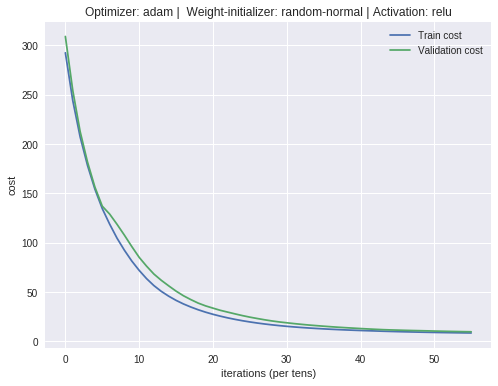

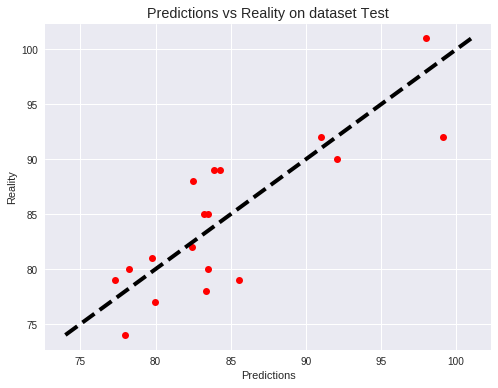

In [0]:
train_rmsle, validation_rmsle, parameters, submission_name = model(train_set, train_label, validation_set, validation_label,
                                                                   set_optimizer = 'adam',
                                                                   weight_initializer='random-normal',
                                                                   hidden_activation='relu' )
plot_prediction(validation_label, predict(validation_set, parameters))


<p><u>Calculating R2 score on validation dataset</u></p>

In [0]:
prediction = predict(validation_set, parameters)
prediction = list(list(np.reshape(prediction, (1,np.product(prediction.shape))))[0])
actual = list(list(np.reshape(validation_label, (1,np.product(validation_label.shape))))[0])
r2_score(actual,prediction)

0.6671229279212032

<p><u>Running a grid-search</u><br>The above R2 score was not too good. We need to figure out whether there is scope to increase the score or not. Lets run a grid-search on the combinations of Optimizer, Weight-initializers and Activations and find the best combination that reduces the validation-error to minimum</p>

In [0]:
param_grid = {'Optimizer':['adam','RMS-Prop'],
              'Initializer':['xavier','random-normal'],
              'Activation':['relu','sigmoid','leaky-relu']}
grid = ParameterGrid(param_grid)
all_combinations = []
all_train_error = []
all_validation_error = []
all_train_val_error_difference = []

for params in grid:
    train_rmsle, validation_rmsle, parameters, submission_name = model(train_set, train_label, validation_set, validation_label,
                                                                       hidden_activation=params['Activation'],
                                                                       weight_initializer = params['Initializer'],
                                                                       show_result=False,plot_cost=False,
                                                                       set_optimizer = params['Optimizer'])
    all_combinations.append(str(list(params.values())))
    all_train_error.append(train_rmsle)
    all_validation_error.append(validation_rmsle)
    all_train_val_error_difference.append(abs(validation_rmsle-train_rmsle))
parameter_combinations = pd.DataFrame(
    {'Combination': all_combinations,
     'Train-error': all_train_error,
     'Validation-error': all_validation_error,
     'Error-difference': all_train_val_error_difference
    })
parameter_combinations = parameter_combinations.sort_values(by='Validation-error', ascending=True)
parameter_combinations[:10]

,Combination,Error-difference,Train-error,Validation-error
0,"['relu', 'xavier', 'adam']",0.0051,0.0357,0.0408
8,"['leaky-relu', 'xavier', 'adam']",0.0044,0.0366,0.0410
10,"['leaky-relu', 'random-normal', 'adam']",0.0054,0.0357,0.0411
2,"['relu', 'random-normal', 'adam']",0.0091,0.0339,0.0430
1,"['relu', 'xavier', 'RMS-Prop']",0.0152,0.0405,0.0557
11,"['leaky-relu', 'random-normal', 'RMS-Prop']",0.0158,0.0414,0.0572
9,"['leaky-relu', 'xavier', 'RMS-Prop']",0.0118,0.0480,0.0598
3,"['relu', 'random-normal', 'RMS-Prop']",0.0242,0.0359,0.0601
6,"['sigmoid', 'random-normal', 'adam']",0.0168,0.9468,0.9636
4,"['sigmoid', 'xavier', 'adam']",0.0176,0.9908,1.0083


<p><u>Applying the best combination</u></p>

Train RMS error: 3.0394
Validation RMS error: 3.5264
Train RMS Log error: 0.0349
Validation RMS Log error: 0.0412


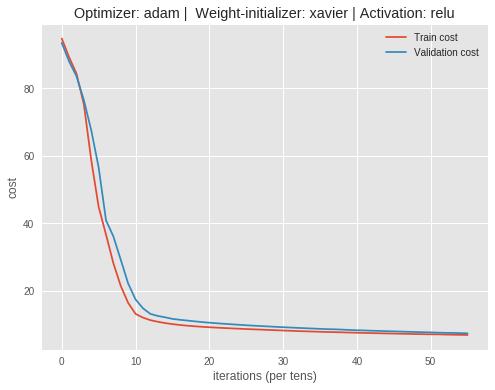

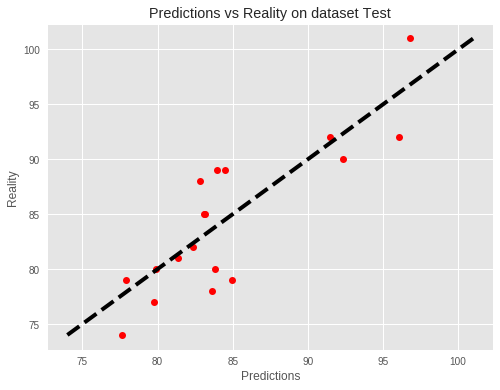

In [0]:
train_rmsle, validation_rmsle, parameters, submission_name = model(train_set, train_label, validation_set, validation_label,
                                                                   set_optimizer = 'adam',
                                                                   weight_initializer='xavier',
                                                                   hidden_activation='relu' )
plot_prediction(validation_label, predict(validation_set, parameters))

<p><u>Checking R2 score on validation dataset</u></p>

In [0]:
prediction = predict(validation_set, parameters)
prediction = list(list(np.reshape(prediction, (1,np.product(prediction.shape))))[0])
actual = list(list(np.reshape(validation_label, (1,np.product(validation_label.shape))))[0])
r2_score(actual,prediction)

0.7189729349936604

<p><u>Applying a grid-search to find the best combination of parameters</u><br>Now we can see that the result (R2 score) has been improved. Both train and validation errors have been decreased and the learning-curves have become very simplified.<br>Now lets apply another grid-search to find the best combination of the tunnable hyper-parameters that reduces the errors to the minimum. Now the grid-search will be performed by involving 4 parameters-Regularization-constant(l2_beta) and Keep_prob to hangle the drop-out of neurons. Learn-rate and Decay of learning-rate(lr_decay)  are responsible for controlling the learning-speed.</p>

In [0]:
param_grid = {'keep_prob':[0.5,0.7,1.0],
              'learn-rate':[0.5e-2,1e-2,1.5e-2],
              'lr_decay':[0,0.02e-2,0.01e-2],
              'l2_beta':[0,0.5,1,2]}
grid = ParameterGrid(param_grid)
all_combinations = []
all_train_error = []
all_validation_error = []
all_train_val_error_difference = []
for params in grid:
    train_rmsle, validation_rmsle, parameters, submission_name = model(train_set, train_label, validation_set, validation_label,
                                                                       hidden_activation='relu',
                                                                       weight_initializer='xavier', 
                                                                       set_optimizer = 'adam',
                                                                       keep_prob=params['keep_prob'],
                                                                       learning_rate=params['learn-rate'],
                                                                       print_cost=False, plot_cost=False,show_result=False,
                                                                       l2_beta=params['l2_beta'],return_best=False,
                                                                       lr_decay=params['lr_decay'])
    all_combinations.append(str(params))
    all_train_error.append(train_rmsle)
    all_validation_error.append(validation_rmsle)
    all_train_val_error_difference.append(abs(validation_rmsle-train_rmsle))
pd.options.display.max_colwidth = 140   
parameter_combinations = pd.DataFrame(
    {'Combination': all_combinations,
     'Train-error': all_train_error,
     'Validation-error': all_validation_error,
     'Error-difference': all_train_val_error_difference
    })
parameter_combinations = parameter_combinations.sort_values(by='Validation-error', ascending=True)
parameter_combinations[:10]

,Combination,Error-difference,Train-error,Validation-error
89,"{'keep_prob': 1.0, 'l2_beta': 0.5, 'learn-rate': 0.015, 'lr_decay': 0.0001}",0.0033,0.0373,0.0406
95,"{'keep_prob': 1.0, 'l2_beta': 1, 'learn-rate': 0.01, 'lr_decay': 0.0001}",0.0032,0.0375,0.0407
94,"{'keep_prob': 1.0, 'l2_beta': 1, 'learn-rate': 0.01, 'lr_decay': 0.0002}",0.0033,0.0375,0.0408
86,"{'keep_prob': 1.0, 'l2_beta': 0.5, 'learn-rate': 0.01, 'lr_decay': 0.0001}",0.0049,0.0359,0.0408
93,"{'keep_prob': 1.0, 'l2_beta': 1, 'learn-rate': 0.01, 'lr_decay': 0}",0.0033,0.0375,0.0408
88,"{'keep_prob': 1.0, 'l2_beta': 0.5, 'learn-rate': 0.015, 'lr_decay': 0.0002}",0.0036,0.0372,0.0408
84,"{'keep_prob': 1.0, 'l2_beta': 0.5, 'learn-rate': 0.01, 'lr_decay': 0}",0.0056,0.0352,0.0408
90,"{'keep_prob': 1.0, 'l2_beta': 1, 'learn-rate': 0.005, 'lr_decay': 0}",0.0038,0.0370,0.0408
91,"{'keep_prob': 1.0, 'l2_beta': 1, 'learn-rate': 0.005, 'lr_decay': 0.0002}",0.0038,0.0371,0.0408
92,"{'keep_prob': 1.0, 'l2_beta': 1, 'learn-rate': 0.005, 'lr_decay': 0.0001}",0.0038,0.0370,0.0409


<p>Here the first combination is the one that reduces the validation error to minimum. Now lets run another grid-search on number of epochs and hidden-neurons to find their best combination that minimizes validation error</p>

In [0]:
param_grid = {'hidden_neurons':[20,40,50,100],
              'num_epochs':[250,500,1000,1500]}
grid = ParameterGrid(param_grid)
all_combinations = []
all_train_error = []
all_validation_error = []
all_train_val_error_difference = []
for params in grid:
    train_rmsle, validation_rmsle, parameters, submission_name = model(train_set, train_label, validation_set, validation_label,
                                                                       hidden_activation='relu',
                                                                       weight_initializer='xavier', 
                                                                       set_optimizer = 'adam',
                                                                       keep_prob=1.0,learning_rate=0.015,
                                                                       num_epochs = params['num_epochs'],
                                                                       print_cost=False, plot_cost=False,show_result=False,
                                                                       l2_beta=0.5,return_best=False,lr_decay=0,
                                                                       hidden_neurons = params['hidden_neurons'])
    all_combinations.append(str(params))
    all_train_error.append(train_rmsle)
    all_validation_error.append(validation_rmsle)
    all_train_val_error_difference.append(abs(validation_rmsle-train_rmsle))
pd.options.display.max_colwidth = 140   
parameter_combinations = pd.DataFrame(
    {'Combination': all_combinations,
     'Train-error': all_train_error,
     'Validation-error': all_validation_error,
     'Error-difference': all_train_val_error_difference
    })
parameter_combinations = parameter_combinations.sort_values(by='Validation-error', ascending=True)
parameter_combinations[:10]

,Combination,Error-difference,Train-error,Validation-error
1,"{'hidden_neurons': 20, 'num_epochs': 500}",0.0034,0.0371,0.0406
9,"{'hidden_neurons': 50, 'num_epochs': 500}",0.0031,0.0378,0.0408
0,"{'hidden_neurons': 20, 'num_epochs': 250}",0.0047,0.0362,0.0409
5,"{'hidden_neurons': 40, 'num_epochs': 500}",0.0030,0.0381,0.0411
12,"{'hidden_neurons': 100, 'num_epochs': 250}",0.0054,0.0361,0.0414
8,"{'hidden_neurons': 50, 'num_epochs': 250}",0.0069,0.0347,0.0416
2,"{'hidden_neurons': 20, 'num_epochs': 1000}",0.0040,0.0378,0.0418
4,"{'hidden_neurons': 40, 'num_epochs': 250}",0.0061,0.0357,0.0418
6,"{'hidden_neurons': 40, 'num_epochs': 1000}",0.0025,0.0394,0.0419
3,"{'hidden_neurons': 20, 'num_epochs': 1500}",0.0048,0.0383,0.0431


<p>Now we san see that the first combination minimizers the error to minimum. Lets use all our best parameters and hyper-parameters to train the ANN model</p>

Train RMS error: 3.2497
Validation RMS error: 3.4799
Train RMS Log error: 0.0372
Validation RMS Log error: 0.0406


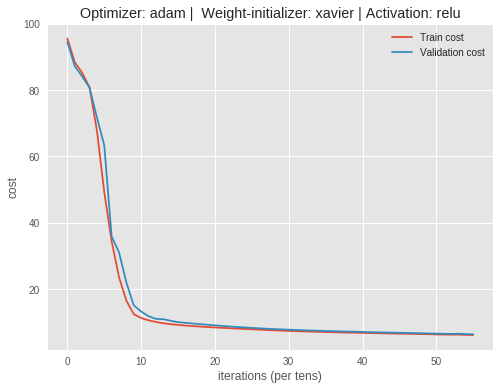

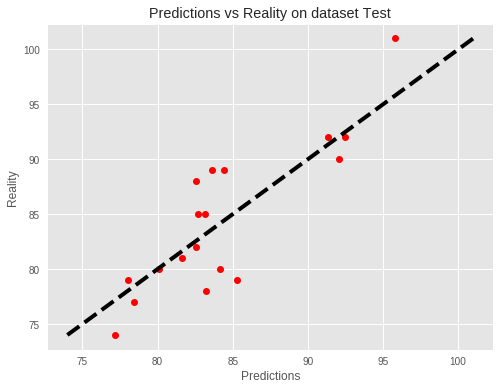

In [0]:
train_rmsle, validation_rmsle, parameters, submission_name = model(train_set, train_label, validation_set, validation_label,
                                                                   hidden_activation='relu',
                                                                   weight_initializer='xavier', 
                                                                   set_optimizer = 'adam',
                                                                   keep_prob=1.0,learning_rate=0.015,num_epochs = 500,
                                                                   print_cost=False, plot_cost=True,show_result=True,
                                                                   l2_beta=0.5,return_best=False,lr_decay=0,
                                                                   hidden_neurons = 20)
plot_prediction(validation_label, predict(validation_set, parameters))

<p><u>Predicting validation dataset using ANN model with best combination of parameters</u></p>

In [0]:
prediction = predict(validation_set, parameters)
prediction = list(list(np.reshape(prediction, (1,np.product(prediction.shape))))[0])
actual = list(list(np.reshape(validation_label, (1,np.product(validation_label.shape))))[0])
r2_score(actual,prediction)

0.7263316263680621

<p>Yes. Now we can see that the accuracy has been increased by a bit. Now lets import another MLP-Regressor neural-network from scikit-learn and compare its performance of predicting validation dataset with respect to our own ANN model</p>

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
hl=[11 for i in range(51)]
hl=tuple(hl)
reg = MLPRegressor(hidden_layer_sizes=hl,activation='identity',solver="adam", \
                                        learning_rate='invscaling',random_state=11)

In [0]:
reg=reg.fit(train_set,train_label)
prediction = list(reg.predict(validation_set))
actual = list(list(np.reshape(validation_label, (1,np.product(validation_label.shape))))[0])
r2_score(actual,prediction)

0.6026441250364258

<p>So we can see that the R2 score for MLP-Regressor ANN model on validation dataset is comperatively lower than our own ANN model. Though the accuracy of the MLP-Regressor could also be increased by tunning the hyperparameters. But for now lets train both models on the whore train-dataset and check their performance of predicting test-dataset </p>

<p><u>Training and predicting with our own ANN model</u></p>

In [0]:
train_rmsle, validation_rmsle, parameters, submission_name = model(train_set_raw,train_label_raw,noneeda,noneedb,
                                                                   hidden_activation='relu',
                                                                   weight_initializer='xavier', 
                                                                   set_optimizer = 'adam',
                                                                   keep_prob=1.0,learning_rate=0.015,num_epochs = 73,
                                                                   print_cost=False, plot_cost=False,show_result=False,
                                                                   l2_beta=0.5,return_best=False,lr_decay=0,
                                                                   hidden_neurons = 20)
prediction = predict(test_set_raw, parameters)
prediction = list(list(np.reshape(prediction, (1,np.product(prediction.shape))))[0])
actual = list(list(np.reshape(test_label_raw, (1,np.product(test_label_raw.shape))))[0])
r2_score(actual,prediction)

0.8696347264744038

<p><u>Training and predicting with Sklearn MLP Regressor ANN model</u></p>

In [0]:
reg=reg.fit(train_set_raw,train_label_raw)
prediction = list(reg.predict(test_set_raw))
actual = list(list(np.reshape(test_label_raw, (1,np.product(test_label_raw.shape))))[0])
prediction = [ math.ceil(elem) for elem in prediction ]
actual_bloom_days_ann = actual
predicted_bloom_days_by_ann = prediction
r2_score(actual,prediction)

0.934402332361516

<p><u>Performance Comparison</u><br>As we can see that both models have shown better r2 score on test-dataset. But the interesting part here is that the accuracy of MLP-Regressor ANN Model is better than our own ANN model. This was quite unexpected because our own model performed better on validation dataset. May be the occurance of such phenomenon is due to the very-small amount of test-data (only 5). Therefore it is quite possible that the MLP regressor model has luckily fitted  better with the samples of test-data.</p> 
  
  <p><u>Decision</u><br>So it can be concluded that an ANN model trained and tested with small-size dataset may produce unpredictable results at times. Though ANN has the potential yet it is a requirement for ANN to have quantity and diversity in number of samples of datsets to ensure better performance.</p>

<p><u>Visualization of predicted-dates for the best ANN model</u></p>

In [0]:
from datetime import datetime, timedelta
actual_bloom_days_ann = np.array(actual_bloom_days_ann).tolist()
actual_bloom_dates_ann = []
predicted_bloom_dates_by_ann = []
difference = []
for count in range(len(actual_bloom_days_ann)):
    index = testdb[(testdb['bloom day'] == actual_bloom_days_ann[count])].index[0]
    year = int(testdb[index:index+1].year)
    predicted_bloomdate = date(year, 1, 1)+timedelta(days=predicted_bloom_days_by_ann[count])
    actual_bloomdate = date(year, 1, 1)+timedelta(days=actual_bloom_days_ann[count])
    actual_bloom_dates_ann.append(actual_bloomdate)
    predicted_bloom_dates_by_ann.append(predicted_bloomdate)

actual_bloom_dates_ann = sorted(actual_bloom_dates_ann)
predicted_bloom_dates_by_ann = sorted(predicted_bloom_dates_by_ann)
for count in range(len(actual_bloom_dates_ann)):
    difference.append(abs(predicted_bloom_dates_by_ann[count] - 
                          actual_bloom_dates_ann[count]).days)
print('Comparison of Predicted-Bloom-dates','\n','with respect to Actual bloom-dates for ANN')  
percentile_list = pd.DataFrame({'Actual-bloom-dates' : actual_bloom_dates_ann,
                                'Predicted-bloom-dates' : predicted_bloom_dates_by_ann,
                                'Prediction-error' : difference})
percentile_list

Comparison of Predicted-Bloom-dates 
 with respect to Actual bloom-dates for ANN


,Actual-bloom-dates,Predicted-bloom-dates,Prediction-error
0,1966-03-20,1966-03-20,0
1,1971-03-30,1971-04-01,2
2,1985-04-03,1985-04-03,0
3,1994-03-31,1994-03-29,2
4,2008-03-22,2008-03-23,1


### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

<p><u>Comparison of different models</u><br>Lets plot the <i>Prediction VS Reality</i> graph from each of the models for better understanding on how properly the models are fitting the test-data.</p>

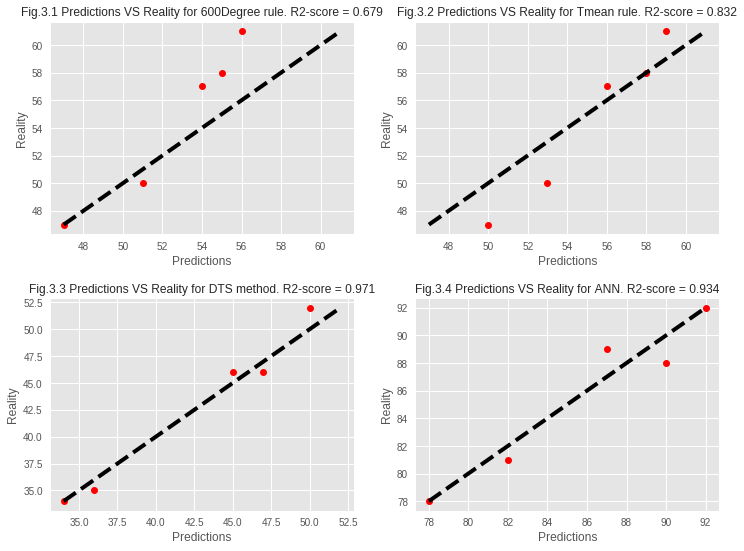

In [0]:
def plot_prediction(actual_labels, prediction,pos,result):
    plt.subplot(2,2,pos)
    plt.style.use('ggplot')
    plt.plot(prediction, actual_labels, 'ro')
    plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'k--', lw=4)
    plt.xlabel('Predictions')
    plt.ylabel('Reality')
    plt.title('Fig.3.'+str(pos)+' Predictions VS Reality for '+result, fontsize=12)
    
resultDts = r2_score(actual_bloom_days_dts,predicted_bloom_days_by_dts)
result600 = r2_score(actual_bloom_days_600degree,predicted_bloom_days_by_t600) 
resultTmean = r2_score(actual_bloom_days_600degree,predicted_bloom_days_by_tmean)
resultAnn = r2_score(actual_bloom_days_ann, predicted_bloom_days_by_ann)

plt.figure(figsize=(12, 9))
plt.subplots_adjust(wspace=None, hspace=0.3)
plot_prediction(actual_bloom_days_600degree,predicted_bloom_days_by_t600,1,
                str('600Degree rule. R2-score = {:.3f}'.format(result600)))
plot_prediction(actual_bloom_days_600degree,predicted_bloom_days_by_tmean,2,
                str('Tmean rule. R2-score = {:.3f}'.format(resultTmean)))
plot_prediction(actual_bloom_days_dts,predicted_bloom_days_by_dts,3,
                str('DTS method. R2-score = {:.3f}'.format(resultDts)))
plot_prediction(actual_bloom_days_ann,predicted_bloom_days_by_ann,4,
                str('ANN. R2-score = {:.3f}'.format(resultAnn)))
plt.show()

<p><u>All plot discussions</u></p><br>
  <ul><u>0.1</u>The performance of Tmean rule(Fig. 3.2) is better than 600 degree rule(Fig. 3.1). This is because the Tmean(=638) value has been modified forTokyo which is 38 degree higher than 600 degree centigrade. The Tmean-rule performs better but it was not that much accurate as two dots are placed far away from marginal line (Fig. 3.2)</ul>
  
  <ul><u>0.2</u>The DTS method (Fig.3.3) perfoms better than the 600 Degree and Tmean Rule which is obvious because the previous Rules take into account only one feature(Daily Max Temperature) whereas the DTS method goes for a more sophisticated approach taking into account Hibernation pattern, Temperature, Activation Energy, Standard Reaction Time etc. The method has recorded highest R2 score on test dataset.</ul>
  
<ul><u>0.3</u>Now the Neural Network also performs well (Fig.3.4). One of the major advantage of using ANN is their ability to solve a prediction problem by just analysing the data-pattern. We do not need to define any mathematical rule or algorithm here. But it requires finding the most optimized network by parameter tuning. Another major drawback is that it cannot learn properly from smaller datasets and its performance is quite unpredictable on smaller test-data which is a major concern in our case. Our test data is too small and therefore any of the tunned model may luckily perform well on test data. we cannot simply expect that the network will perform equally well on large datasets too.</ul>

<p><u>Decision</u><br>The DTS method is considered best as its algorithm is well defined and therefore it may perform better on large datasets too. The ANN model also has the potential to perform well. But it needs to be trained and tested using more data for better accuracy</p>

***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

<p><u>Plotting Dj and BDj with respect to all years</u></p>

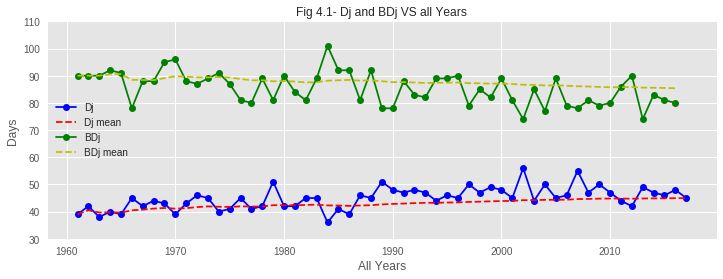

In [0]:
bloom_days = list(sakuradb['bloom day'])
avg_temp = list(sakuradb['avg temp'])
sea_pressure = list(sakuradb['sea pressure'])

addingDj = 0
all_avgDj = []
all_avgBDj = []
for count in range(len(dj_all_by_day)):
    addingDj = addingDj + dj_all_by_day[count]
    avgDj = addingDj/(count+1)
    all_avgDj.append(avgDj)
addingBDj = 0
all_avg = []
for count in range(len(bloom_days)):
    addingBDj = addingBDj+bloom_days[count]
    avgBDj = addingBDj/(count+1)
    all_avgBDj.append(avgBDj)  

plt.subplots(figsize=(12, 4))
plt.plot(allyears,dj_all_by_day,'-bo', label= 'Dj')
plt.plot(allyears,all_avgDj,'--r',label= 'Dj mean')
plt.plot(allyears[0:-1],bloom_days,'-go',label= 'BDj')
plt.plot(allyears[0:-1],all_avgBDj,'--y',label= 'BDj mean')
plt.xlabel('All Years')
plt.ylabel('Days')
plt.ylim(30, 110)
plt.title('Fig 4.1- Dj and BDj VS all Years', Fontsize = 12)
plt.legend()
plt.show()

<p><u>Plotting the Duration of Growth-phase for all years </u></p>

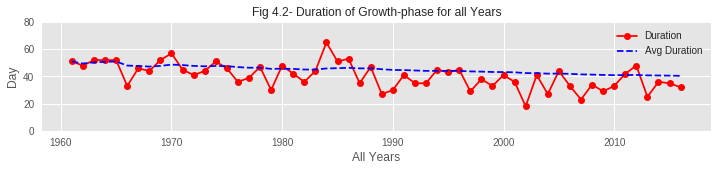

In [0]:
difference=[x1 - x2 for (x1, x2) in zip(bloom_days,dj_all_by_day[0:-1])]
adding = 0
all_avg = []
for count in range(len(difference)):
    adding = adding+difference[count]
    avg = adding/(count+1)
    all_avg.append(avg)

plt.subplots(figsize=(12, 2))
plt.plot(allyears[0:-1],difference,'-ro', label= 'Duration')
plt.plot(allyears[0:-1],all_avg,'--b',label= 'Avg Duration')
plt.xlabel('All Years')
plt.ylabel('Day')
plt.ylim(0, 80)
plt.title('Fig 4.2- Duration of Growth-phase for all Years', Fontsize = 12)
plt.legend()
plt.show()

<p><u>Plotting average temperature of all years</u></p>

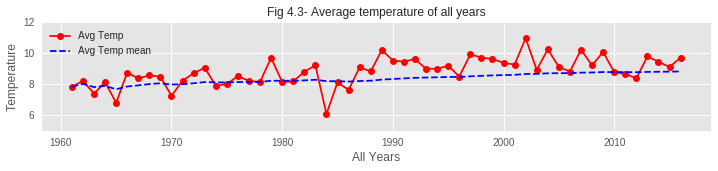

In [0]:
adding = 0
all_avg = []
for count in range(len(avg_temp)):
    adding = adding+avg_temp[count]
    avg = adding/(count+1)
    all_avg.append(avg)
plt.subplots(figsize=(12, 2))
plt.plot(allyears[0:-1],avg_temp,'-ro',label= 'Avg Temp')
plt.plot(allyears[0:-1],all_avg,'--b',label= 'Avg Temp mean')
plt.xlabel('All Years')
plt.ylabel('Temperature')
plt.ylim(5, 12)
plt.title('Fig 4.3- Average temperature of all years', Fontsize = 12) 
plt.legend()
plt.show()

<p>NB- The Average Temperatures  in this plot are calculated for the first four months of each year. The reason is that these months have the most significant impact on bloom-dates.<p>

<p><u>Plotting sea-pressure of all years</u></p>

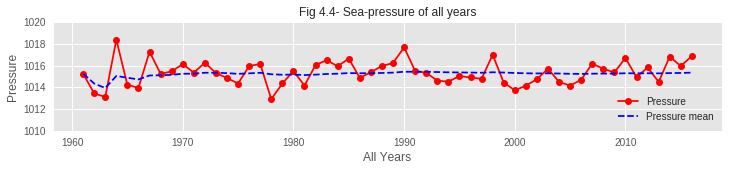

In [0]:
adding = 0
all_avg = []
for count in range(len(sea_pressure)):
    adding = adding+sea_pressure[count]
    avg = adding/(count+1)
    all_avg.append(avg)

plt.subplots(figsize=(12, 2))
plt.plot(allyears[0:-1],sea_pressure,'-ro',label='Pressure')
plt.plot(allyears[0:-1],all_avg,'--b',label='Pressure mean')
plt.xlabel('All Years')
plt.ylabel('Pressure')
plt.ylim(1010, 1020)
plt.title('Fig 4.4- Sea-pressure of all years', Fontsize = 12)
plt.legend()
plt.show()

<p><u>All Plot Discussions</u><br>
<ul><u>01.</u> From the Graphs of 4.1 it is clear that the Hibernation Pattern has changed over the past 60 years. In recent years, the end of Hibernation taking place with a noticeable delay compared to the past years. The reason behind this might be the increase of average-temperature over the years (Fig. 4.3). Due of such increase in temperature of the first few months of recent years, The temperature: TF (Problem 2-1)  is rising and therefore increasing Dj value. So hibernation phase is delaying to end.</ul>
<ul><u>02.</u> From Fig 4.1 it is also observed that BDJmean curve is gradually falling down over the years. That means the bloom is coming earlier in recent years. This phenomena is verified by the Graph of problem 1-1 as it tells that the Accumulated Max Temperature of hybernation phase has decreased over the years.</ul>
<ul><u>03.</u> As hibernation is delaying to end but bloom is coming earlier, the duration of growth-period of sakura-buds is shrinking over the years (Fig. 4.2). From my assumption global warming might be a reason behind this. Due to global-warming average temperature is gradually rising (Fig 4.3) and spring is coming a bit earlier in every year and making Sakura-buds to bloom earlier than the previous years.</ul>
<ul><u>04.</u>Though the average sea-pressure is found almost constant over the years, It is seen rising in very recent years (Fig. 4.4).Sea-pressure of recent years has merely dropped below the average-line. This may have impact on early-blooming </ul></p>